In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My\ Drive/masters

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/gdrive/My Drive/masters


In [4]:
%ls ./data/processed

# T1H-X1700M-Y1760M/  T24H-X850M-Y880M/  T3H-X850M-Y880M/
# T12H-X850M-Y880M/  T24H-X425M-Y440M/   T24H-X85M-Y110M/   T6H-X850M-Y880M/

MOCK-DATA/         T1H-X1700M-Y1760M/  T24H-X850M-Y880M/  T3H-X850M-Y880M/
T12H-X850M-Y880M/  T24H-X425M-Y440M/   T24H-X85M-Y110M/   T6H-X850M-Y880M/


In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from models.model_result import ModelResult

In [2]:
data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  # needs to exist
model_name = "FNN-CRIME-MODEL"  # needs to be created

data_path = f"./data/processed/{data_dim_str}/"
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

# logging config is set globally thus we only need to call this in this file
# imported function logs will follow the configuration
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")

timer = Timer()
# manually set the config
conf_dict = {
    "seed":3,
    "resume":False,
    "early_stopping":False,
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,    
    "use_cuda":False,
    "val_ratio":0.1,
    "tst_ratio":0.2,
    "flatten_grid": True,
    "lr":5e-3,
    "weight_decay":1e-8,
    "max_epochs":1,
    "batch_size":256,
    "dropout": 0.1,
    "shuffle":False,
    "seq_len":1,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed(conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
log.info(f"Device: {device}")
info["device"] = device.type

# GET DATA
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

2019-09-30T08:23:00 | root | INFO | =====================================BEGIN=====================================
2019-09-30T08:23:00 | root | INFO | Device: cpu
2019-09-30T08:23:00 | root | INFO | Data shapes of files in generated_data.npz
2019-09-30T08:23:00 | root | INFO | 	crime_feature_indices shape (11,)
2019-09-30T08:23:01 | root | INFO | 	crime_types_grids shape (365, 11, 47, 33)
2019-09-30T08:23:01 | root | INFO | 	crime_grids shape (365, 1, 47, 33)
2019-09-30T08:23:01 | root | INFO | 	demog_grid shape (1, 37, 47, 33)
2019-09-30T08:23:01 | root | INFO | 	street_grid shape (1, 512, 47, 33)
2019-09-30T08:23:01 | root | INFO | 	time_vectors shape (366, 52)
2019-09-30T08:23:01 | root | INFO | 	weather_vectors shape (365, 11)
2019-09-30T08:23:01 | root | INFO | 	x_range shape (33,)
2019-09-30T08:23:01 | root | INFO | 	y_range shape (47,)
2019-09-30T08:23:01 | root | INFO | 	t_range shape (366,)


In [3]:
# SET MODEL PARAMS
train_set = loaders.training_generator.dataset
spc_feats, tmp_feats, env_feats, target = train_set[train_set.min_index]
spc_size, tmp_size, env_size = spc_feats.shape[-1], tmp_feats.shape[-1], env_feats.shape[-1]

model = KangFeedForwardNetwork(spc_size=spc_size, tmp_size=tmp_size, env_size=env_size, dropout_p=conf.dropout)
model.to(device)

KangFeedForwardNetwork(
  (dropout): Dropout(p=0.1)
  (spcNet): Sequential(
    (0): Linear(in_features=37, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (tmpNet): Sequential(
    (0): Linear(in_features=75, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (envNet): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
  )
  (finalNet): Sequential(
    (0): Linear(in_features=384, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=T

In [4]:
loss_function = nn.CrossEntropyLoss()

trn_loss = []
val_loss = []
val_loss_best = float("inf")

all_trn_loss = []
all_val_loss = []

optimiser = optim.Adam(params=model.parameters(), lr=conf.lr, weight_decay=conf.weight_decay)
if conf.resume:
    # load model and optimiser states
    model_state_dict = torch.load(model_path + "model_best.pth", map_location=device.type)
    model.load_state_dict(model_state_dict)
    optimiser_state_dict = torch.load(model_path + "optimiser_best.pth", map_location=device.type)
    optimiser.load_state_dict(optimiser_state_dict)
    # load losses
    losses_zip = np.load(model_path + "losses.npz")
    all_val_loss = losses_zip["all_val_loss"].tolist()
    val_loss = losses_zip["val_loss"].tolist()
    trn_loss = losses_zip["trn_loss"].tolist()
    all_trn_loss = losses_zip["all_trn_loss"].tolist()
    val_loss_best = float(losses_zip["val_loss_best"])
    # todo only load loss since last best_checkpoint

In [5]:
spc_feats, tmp_feats, env_feats, targets = next(iter(loaders.validation_generator))
for i in [spc_feats, tmp_feats, env_feats, targets]:
    print(i.shape)

(1, 256, 37)
(1, 256, 75)
(1, 256, 512)
(1, 256, 1)


In [6]:
d = loaders.validation_generator.dataset

spc_feats, tmp_feats, env_feats, targets = d[d.min_index:d.min_index+10]
for i in [spc_feats, tmp_feats, env_feats, targets]:
    print(i.shape,end='')

(1, 10, 37)(1, 10, 75)(1, 10, 512)(1, 10, 1)

In [7]:
for (j,(spc_feats, tmp_feats, env_feats, targets)) in enumerate(loaders.validation_generator):
    for i in [spc_feats, tmp_feats, env_feats, targets]:
        print(i.shape,end='')
    print(j)  
    break

(1, 256, 37)(1, 256, 75)(1, 256, 512)(1, 256, 1)0


In [14]:
for epoch in range(conf.max_epochs):
    log.info(f"Epoch: {(1+epoch):04d}/{conf.max_epochs:04d}")
    timer.reset()
    # Training loop
    tmp_trn_loss = []
    num_batches = loaders.training_generator.num_batches
    for spc_feats, tmp_feats, env_feats, targets in loaders.training_generator:
        current_batch = loaders.training_generator.current_batch
        
        # Transfer to PyTorch Tensor and GPU
        spc_feats = torch.Tensor(spc_feats[0]).to(device) # only taking [0] for fnn
        tmp_feats = torch.Tensor(tmp_feats[0]).to(device) # only taking [0] for fnn
        env_feats = torch.Tensor(env_feats[0]).to(device) # only taking [0] for fnn
        targets = torch.LongTensor(targets[0,:,0]).to(device) # only taking [0] for fnn
        out = model(spc_feats, tmp_feats, env_feats)
        loss = loss_function(input=out, target=targets)
        tmp_trn_loss.append(loss.item())
        all_trn_loss.append(tmp_trn_loss[-1])

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        log.debug(f"Batch: {current_batch:04d}/{num_batches:04d} \t Loss: {tmp_trn_loss[-1]:.4f}")
    trn_loss.append(np.mean(tmp_trn_loss))
    log.debug(f"Epoch {epoch} -> Training Loop Duration: {timer.check()}")
    timer.reset()

    # Validation loop
    tmp_val_loss = []
    with torch.set_grad_enabled(False):
        # Transfer to GPU
        for spc_feats, tmp_feats, env_feats, targets in loaders.validation_generator:
            # Transfer to GPU
            spc_feats = torch.Tensor(spc_feats[0]).to(device)  # only taking [0] for fnn
            tmp_feats = torch.Tensor(tmp_feats[0]).to(device)  # only taking [0] for fnn
            env_feats = torch.Tensor(env_feats[0]).to(device)  # only taking [0] for fnn
            targets = torch.LongTensor(targets[0,:,0]).to(device)  # only taking [0] for fnn
            out = model(spc_feats, tmp_feats, env_feats)

            loss = loss_function(input=out, target=targets)
            tmp_val_loss.append(loss.item())
            all_val_loss.append(tmp_val_loss[-1])
    val_loss.append(np.mean(tmp_val_loss))
    log.debug(f"Epoch {epoch} -> Validation Loop Duration: {timer.check()}")

    log.info(f"\tLoss (Trn): \t{trn_loss[-1]:.5f}")
    log.info(f"\tLoss (Val): \t{val_loss[-1]:.5f}")
    log.info(f"\tLoss (Dif): \t{np.abs(val_loss[-1]-trn_loss[-1]):.5f}\n")        
    


    # save best model
    if min(val_loss) < val_loss_best:
        val_loss_best = min(val_loss)
        torch.save(model.state_dict(), model_path + "model_best.pth")
        torch.save(optimiser.state_dict(), model_path + "optimiser_best.pth")

    # model has been over-fitting stop maybe? # average of val_loss has increase - starting to over-fit
    if conf.early_stopping and epoch != 0 and val_loss[-1] > val_loss[-2]:
        log.warning("Over-fitting has taken place - stopping early")
        break

    # checkpoint - save models and loss values
    torch.save(model.state_dict(), model_path + "model.pth")
    torch.save(optimiser.state_dict(), model_path + "optimiser.pth")
    np.savez_compressed(model_path + "losses.npz",
                        all_val_loss=all_val_loss,
                        val_loss=val_loss,
                        trn_loss=trn_loss,
                        all_trn_loss=all_trn_loss,
                        val_loss_best=val_loss_best)

2019-09-29T22:15:57 | root | INFO | Epoch: 0001/0001
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch

out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.

out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.

out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.shape torch.Size([256])
out.shape torch.Size([256, 2]), targets.

KeyboardInterrupt: 

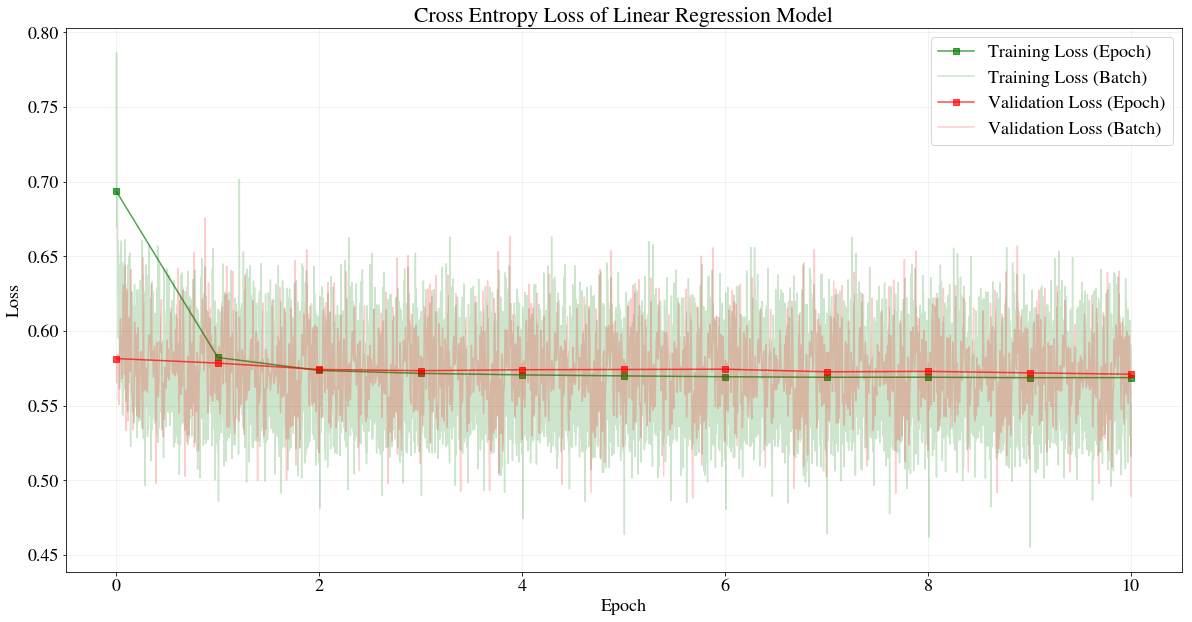

In [29]:
# Save training and validation plots
skip = 0
loss_plotter = LossPlotter(title="Cross Entropy Loss of Linear Regression Model")
loss_plotter.plot_losses(trn_loss, all_trn_loss[skip:], val_loss, all_val_loss[skip:])
loss_plotter.savefig(model_path + "plot_train_val_loss.png")

# todo evaluation prediction formating into an actual map

2019-08-22T09:37:33 | root | INFO | Data shapes of files in generated_data.npz
2019-08-22T09:37:33 | root | INFO | 	crime_feature_indices shape (11,)
2019-08-22T09:37:34 | root | INFO | 	crime_types_grids shape (8760, 11, 24, 16)
2019-08-22T09:37:34 | root | INFO | 	crime_grids shape (8760, 1, 24, 16)
2019-08-22T09:37:34 | root | INFO | 	demog_grid shape (1, 37, 24, 16)
2019-08-22T09:37:34 | root | INFO | 	street_grid shape (1, 512, 24, 16)
2019-08-22T09:37:34 | root | INFO | 	time_vectors shape (8761, 66)
2019-08-22T09:37:34 | root | INFO | 	weather_vectors shape (8760, 11)
2019-08-22T09:37:34 | root | INFO | 	x_range shape (16,)
2019-08-22T09:37:34 | root | INFO | 	y_range shape (24,)
2019-08-22T09:37:34 | root | INFO | 	t_range shape (8761,)
2019-08-22T09:37:42 | root | INFO | 
            Model Name: FNN (Kang and Kang)
                ROC AUC:            0.7621928034605785
                Average Precision:  0.25598413334179854
                Accuracy:           0.683023986293546

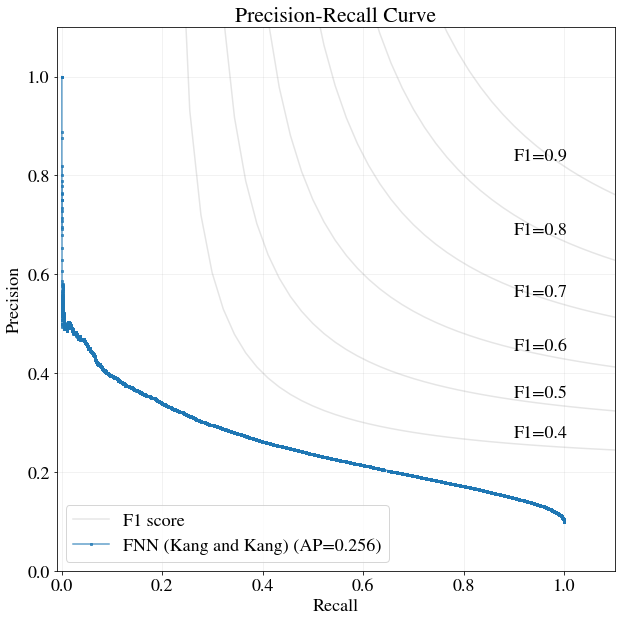

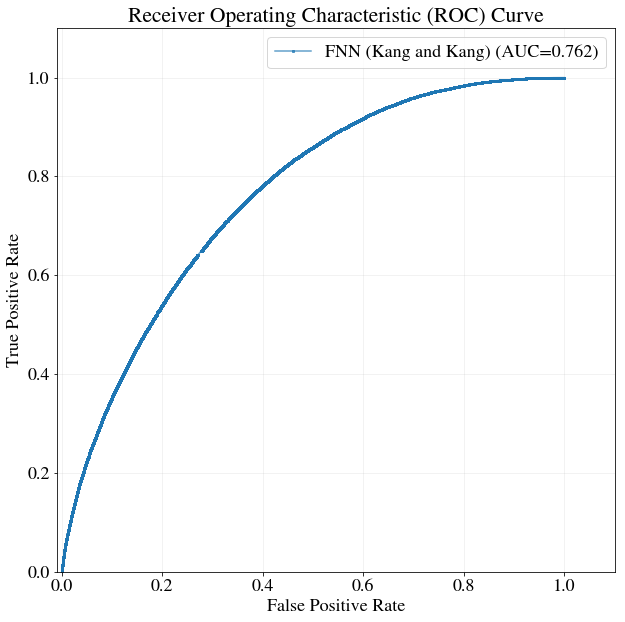

In [30]:
model.load_state_dict(torch.load(model_path + "model_best.pth"))
conf = BaseConf(conf_dict=conf_dict)
loaders = FlatDataLoaders(data_path=data_path, conf=conf)

# EVALUATE MODEL
with torch.set_grad_enabled(False):
    # Transfer to GPU
    testing_losses = []
    y_true = []
    y_pred = []
    probas_pred = []
    
    # loop through is set does not fit in batch
    for spc_feats, tmp_feats, env_feats, targets in loaders.testing_generator: 
        """
        IMPORTNANT NOTE: WHEN DOING LSTM - ONLY FEED THE TEMPORAL VECTORS IN THE LSTM
        FEED THE REST INTO THE NORMAL LINEAR NETWORKS
        """
        
        
        # Transfer to GPU
        spc_feats = torch.Tensor(spc_feats).to(device)
        tmp_feats = torch.Tensor(tmp_feats).to(device)
        env_feats = torch.Tensor(env_feats).to(device)
        targets = torch.LongTensor(targets).to(device)
        
        y_true.extend(targets.tolist())
        out = model(spc_feats, tmp_feats, env_feats)
        out = F.softmax(out, dim=1)
        out_label = torch.argmax(out, dim=1)
        y_pred.extend(out_label.tolist())
        out_proba = out[:, 1]  # likelihood of crime is more general form - when comparing to moving averages
        probas_pred.extend(out_proba.tolist())

        
model_result = ModelResult(model_name="FNN (Kang and Kang)",
                            y_true=y_true,
                            y_pred=y_pred,
                            probas_pred=probas_pred,
                            t_range=loaders.testing_generator.dataset.t_range,
                            shape=None)  # todo change to be the shape (N,L) of the original prediction.
                        
log.info(model_result)

np.savez_compressed(model_path + "evaluation_results.npz", model_result)

pr_plotter = PRCurvePlotter()
pr_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
roc_plotter.add_curve(y_true, probas_pred, label_name="FNN (Kang and Kang)")
roc_plotter.savefig(model_path + "plot_roc_curve.png")

info["stop_time"] = strftime("%Y-%m-%dT%H:%M:%S")
write_json(info, model_path + "info.json")

log.info("=====================================END=====================================")